In [31]:
import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import statsmodels.api as sm
import statsmodels


from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [32]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")


In [33]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

# Funtions

In [34]:
# base code
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-paper', **kwargs):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        
        try: 
            vif_df["Features"] = self.xvar_names
            vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

            return (vif_df
                    .sort_values("VIF Factor")
                    .round(2))
        finally:
            return vif_df

    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y


# Load Data

In [35]:
#  Set start date
start_date = datetime.date(1982, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'
unemployment_rate_code = 'UNRATE'
cpi_code = 'CORESTICKM157SFRBATL'
#CPIAUCSL
#CORESTICKM157SFRBATL
#ff_rate_code = 'EFFR'
real_rate_code = 'REAINTRATREARAT1MO'


#  Fetch data
unemployment_rate_df = pdr.DataReader(unemployment_rate_code, data_source, start_date)
cpi_df = pdr.DataReader(cpi_code, data_source, start_date)
#ff_rate_df = pdr.DataReader(ff_rate_code, data_source, start_date)
real_rate_df = pdr.DataReader(real_rate_code, data_source, start_date)

In [36]:
df = pd.concat([unemployment_rate_df,cpi_df,real_rate_df], axis=1)
#df.reset_index(inplace=True)
df.sort_index(inplace=True)
#df.asfreq('1D')
df.columns = ['un_emp_rate','cpi_rate','real_rate']
df

,un_emp_rate,cpi_rate,real_rate
DATE,,,
1982-01-01,8.6,0.368790,2.464018
1982-02-01,8.9,0.427160,4.981599
1982-03-01,9.0,-0.020060,7.594187
1982-04-01,9.3,0.907520,8.803434
1982-05-01,9.4,1.110180,8.567456
...,...,...,...
2023-05-01,3.7,0.324257,1.607673
2023-06-01,3.6,0.233532,6.004632
2023-07-01,3.5,0.264675,2.854389


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 1982-01-01 to 2023-09-01
Freq: MS
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   un_emp_rate  500 non-null    float64
 1   cpi_rate     500 non-null    float64
 2   real_rate    501 non-null    float64
dtypes: float64(3)
memory usage: 15.7 KB


# Analysis

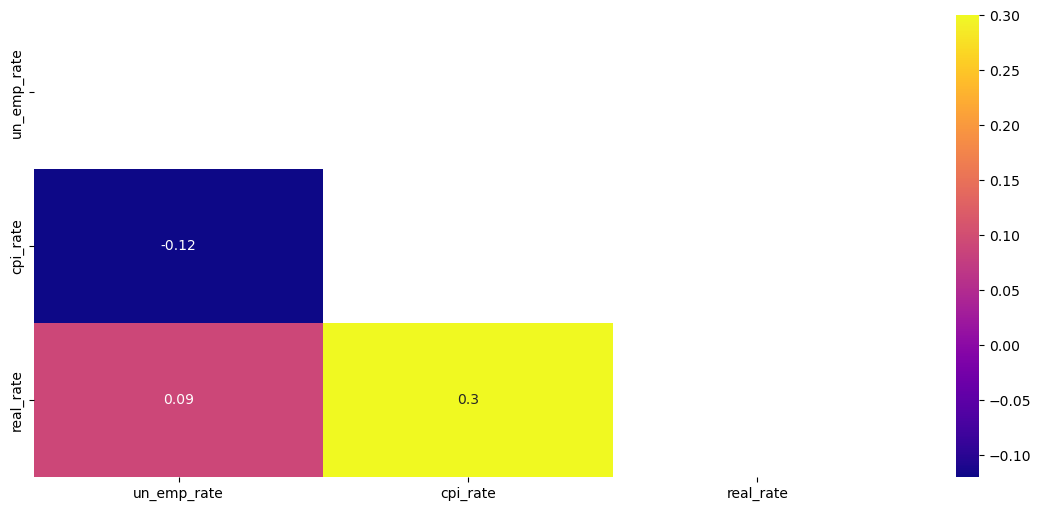

In [38]:
t_df = df

plt.figure(figsize=(14,6))
mask = np.zeros_like(t_df.corr())
mask[np.triu_indices_from(mask)] = True
_p = sns.heatmap(t_df.corr().round(2), annot=True, mask=mask, cmap="plasma")

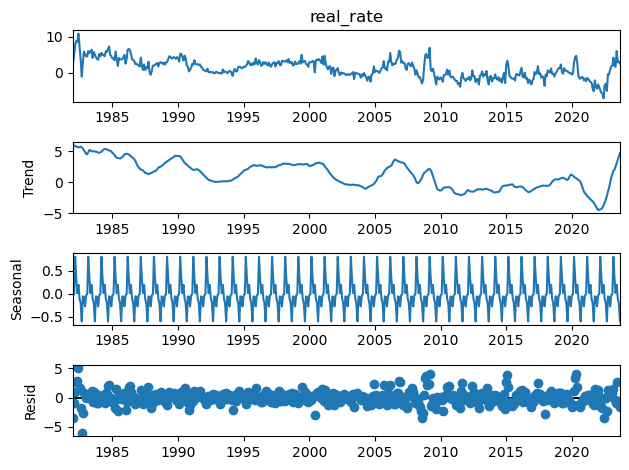

In [39]:
decomposition = sm.tsa.seasonal_decompose(df['real_rate'], model='additive', 
                            extrapolate_trend='freq') #additive or multiplicative is data specific
fig = decomposition.plot()
plt.show()

In [40]:
#col_lst = list(df.columns)
#col_lst

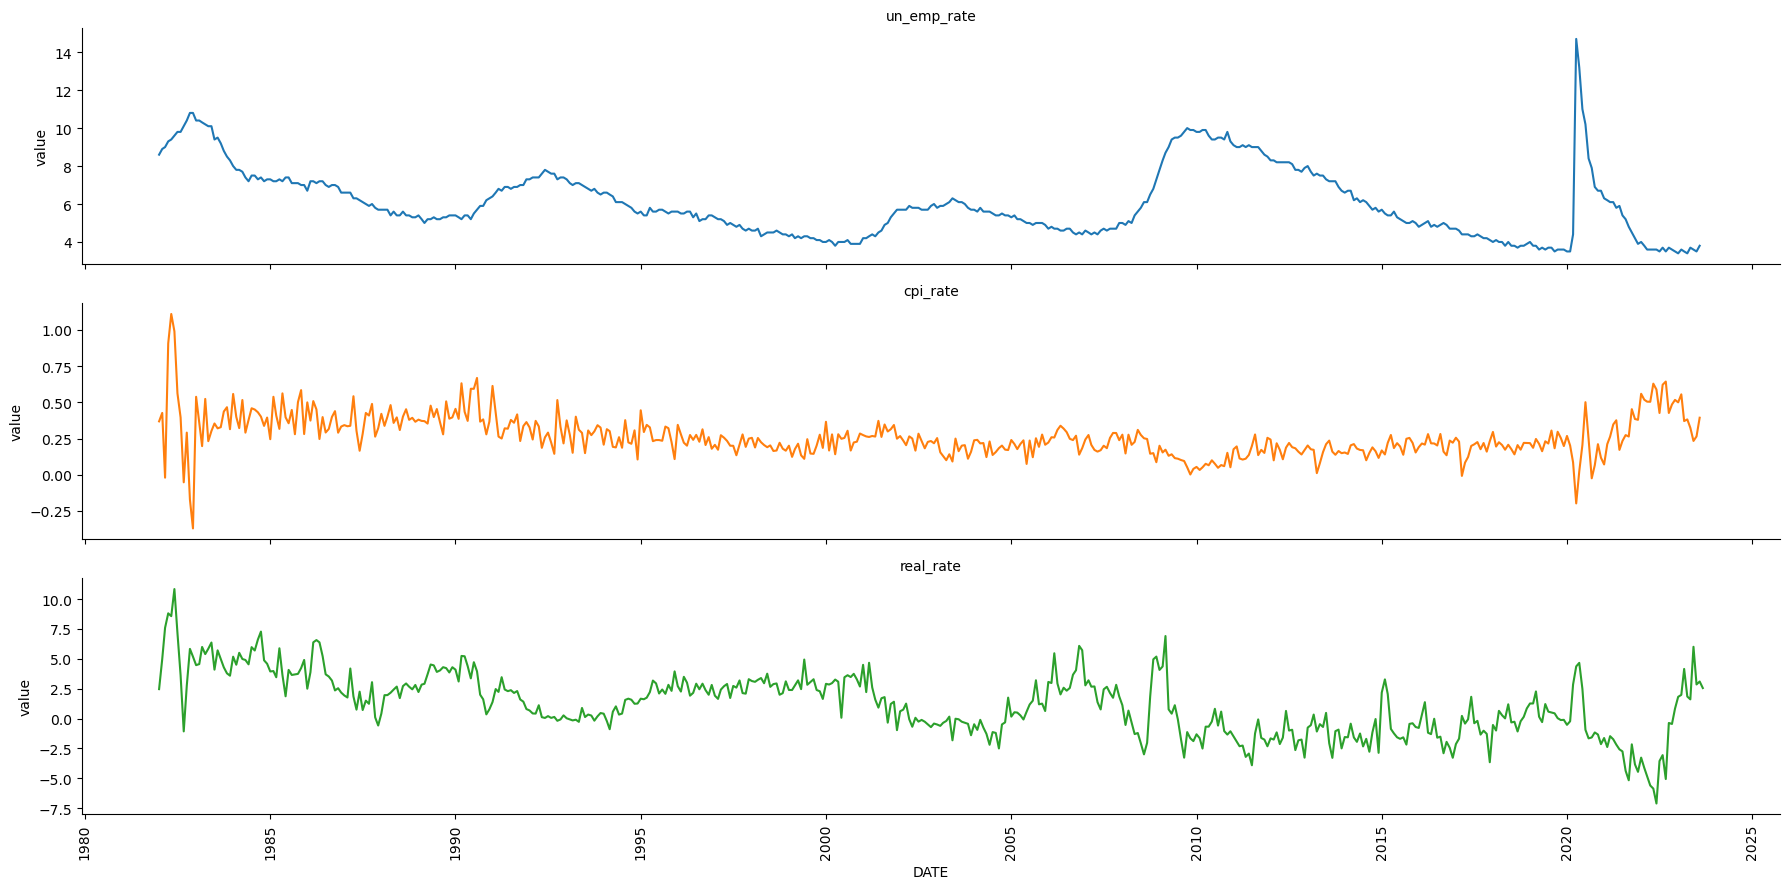

In [41]:
long_df = df.copy()
long_df.reset_index(inplace=True)

long_df = long_df.melt(id_vars=['DATE'])


# Graph
g = sns.FacetGrid(long_df, col='variable', hue='variable',
                  height=3, aspect=6,col_wrap=1, sharey=False)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tick_params(axis='x', labelrotation=90) 
g.tight_layout()
g.map_dataframe(sns.lineplot, y="value", x="DATE")

plt.show()

# Trian Test Split

In [42]:
splt_index = round(df.shape[0] * 0.8)
train_df = df[:splt_index].copy()
train_df = train_df.asfreq(freq='1M', how='start', method='ffill', fill_value=0)
train_df.fillna(method='ffill', inplace=True)
train_df

,un_emp_rate,cpi_rate,real_rate
DATE,,,
1982-01-31,8.6,0.368790,2.464018
1982-02-28,8.9,0.427160,4.981599
1982-03-31,9.0,-0.020060,7.594187
1982-04-30,9.3,0.907520,8.803434
1982-05-31,9.4,1.110180,8.567456
...,...,...,...
2014-12-31,5.6,0.116414,-2.865188
2015-01-31,5.7,0.168069,2.172698
2015-02-28,5.5,0.140280,3.278279


In [43]:
test_df = df[splt_index:].copy()
test_df = test_df.asfreq(freq='1M', how='start', method='ffill', fill_value=0)
test_df.fillna(method='ffill', inplace=True)
test_df

,un_emp_rate,cpi_rate,real_rate
DATE,,,
2015-06-30,5.3,0.218324,-1.565294
2015-07-31,5.2,0.195411,-1.693726
2015-08-31,5.1,0.138176,-1.569231
2015-09-30,5.0,0.248410,-2.175163
2015-10-31,5.0,0.254499,-0.445313
...,...,...,...
2023-04-30,3.4,0.382205,1.845097
2023-05-31,3.7,0.324257,1.607673
2023-06-30,3.6,0.233532,6.004632


# Unemployment

## stats model

In [44]:
X = train_df['un_emp_rate']
X = sm.add_constant(X)
X

,const,un_emp_rate
DATE,,
1982-01-31,1.0,8.6
1982-02-28,1.0,8.9
1982-03-31,1.0,9.0
1982-04-30,1.0,9.3
1982-05-31,1.0,9.4
...,...,...
2014-12-31,1.0,5.6
2015-01-31,1.0,5.7
2015-02-28,1.0,5.5


In [45]:
y = train_df['real_rate']
y

DATE
1982-01-31    2.464018
1982-02-28    4.981599
1982-03-31    7.594187
1982-04-30    8.803434
1982-05-31    8.567456
                ...   
2014-12-31   -2.865188
2015-01-31    2.172698
2015-02-28    3.278279
2015-03-31    2.046602
2015-04-30   -0.865592
Freq: M, Name: real_rate, Length: 400, dtype: float64

In [46]:
ols_model = sm.OLS(y, X)
ols_result = ols_model.fit()

In [47]:
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:              real_rate   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.572
Date:                Sun, 24 Sep 2023   Prob (F-statistic):             0.0331
Time:                        14:33:35   Log-Likelihood:                -913.60
No. Observations:                 400   AIC:                             1831.
Df Residuals:                     398   BIC:                             1839.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.6516      0.475      5.579      

In [48]:
cls = LinearRegDiagnostic(ols_result)

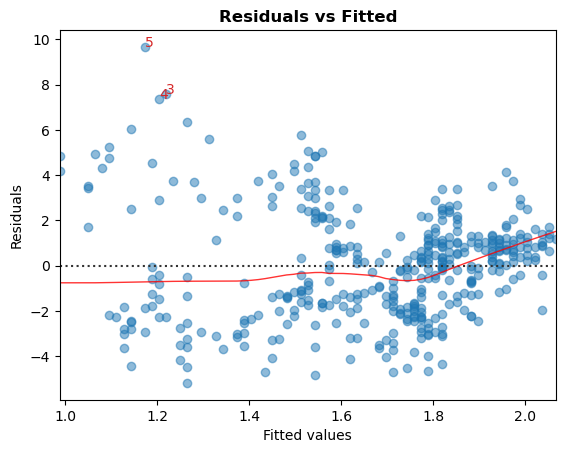

In [49]:
cls.residual_plot();

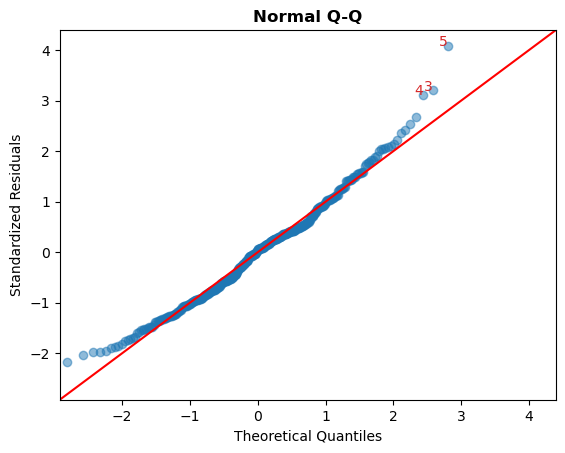

In [50]:
cls.qq_plot();

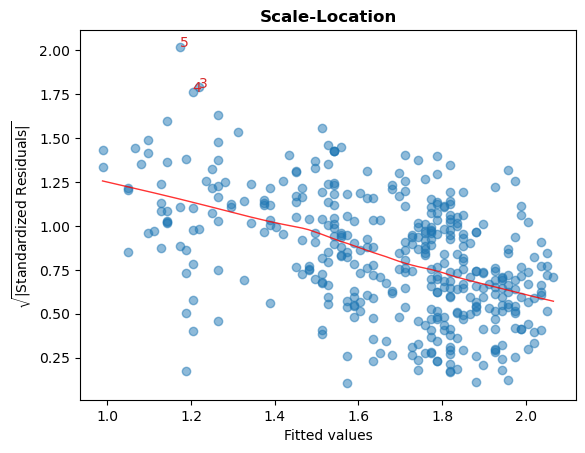

In [51]:
cls.scale_location_plot();

<Axes: title={'center': 'Residuals vs Leverage'}, xlabel='Leverage', ylabel='Standardized Residuals'>

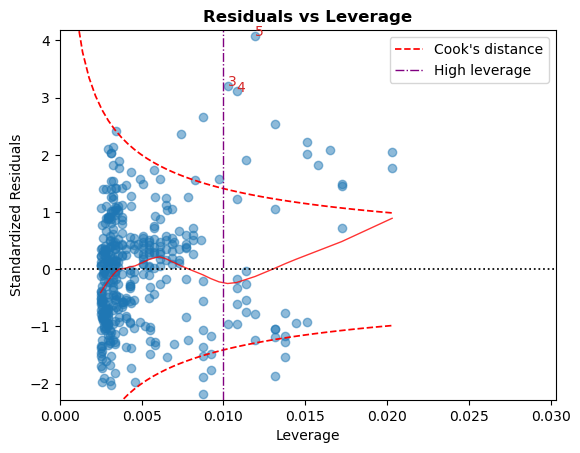

In [52]:
cls.leverage_plot(high_leverage_threshold=True, cooks_threshold='dof')

In [53]:
train_pred = ols_result.predict(X)
train_pred

DATE
1982-01-31    1.327154
1982-02-28    1.280951
1982-03-31    1.265550
1982-04-30    1.219347
1982-05-31    1.203946
                ...   
2014-12-31    1.789186
2015-01-31    1.773785
2015-02-28    1.804587
2015-03-31    1.819988
2015-04-30    1.819988
Freq: M, Length: 400, dtype: float64

In [54]:
t = ols_result.get_prediction(X)
train_pred = t.summary_frame(alpha=0.05)
train_pred

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
DATE,,,,,,
1982-01-31,1.327154,0.198877,0.936173,1.718135,-3.370254,6.024562
1982-02-28,1.280951,0.216572,0.855182,1.706719,-3.419480,5.981382
1982-03-31,1.265550,0.222624,0.827884,1.703216,-3.435974,5.967074
1982-04-30,1.219347,0.241160,0.745241,1.693453,-3.485709,5.924403
1982-05-31,1.203946,0.247449,0.717475,1.690416,-3.502372,5.910263
...,...,...,...,...,...,...
2014-12-31,1.789186,0.131900,1.529879,2.048493,-2.899099,6.477471
2015-01-31,1.773785,0.128963,1.520250,2.027319,-2.914184,6.461754
2015-02-28,1.804587,0.135156,1.538877,2.070296,-2.884057,6.493230


In [55]:
X_test = test_df['un_emp_rate']
X_test = sm.add_constant(X_test)
X_test 

,const,un_emp_rate
DATE,,
2015-06-30,1.0,5.3
2015-07-31,1.0,5.2
2015-08-31,1.0,5.1
2015-09-30,1.0,5.0
2015-10-31,1.0,5.0
...,...,...
2023-04-30,1.0,3.4
2023-05-31,1.0,3.7
2023-06-30,1.0,3.6


In [56]:
t = ols_result.get_prediction(X_test)
test_pred = t.summary_frame(alpha=0.05)
test_pred

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
DATE,,,,,,
2015-06-30,1.835389,0.142541,1.555161,2.115617,-2.854100,6.524877
2015-07-31,1.850790,0.146625,1.562533,2.139047,-2.839185,6.540765
2015-08-31,1.866191,0.150943,1.569446,2.162936,-2.824313,6.556696
2015-09-30,1.881592,0.155474,1.575938,2.187246,-2.809484,6.572669
2015-10-31,1.881592,0.155474,1.575938,2.187246,-2.809484,6.572669
...,...,...,...,...,...,...
2023-04-30,2.128009,0.245967,1.644453,2.611565,-2.578009,6.834027
2023-05-31,2.081806,0.227299,1.634949,2.528663,-2.620582,6.784194
2023-06-30,2.097207,0.233465,1.638228,2.556186,-2.606349,6.800763


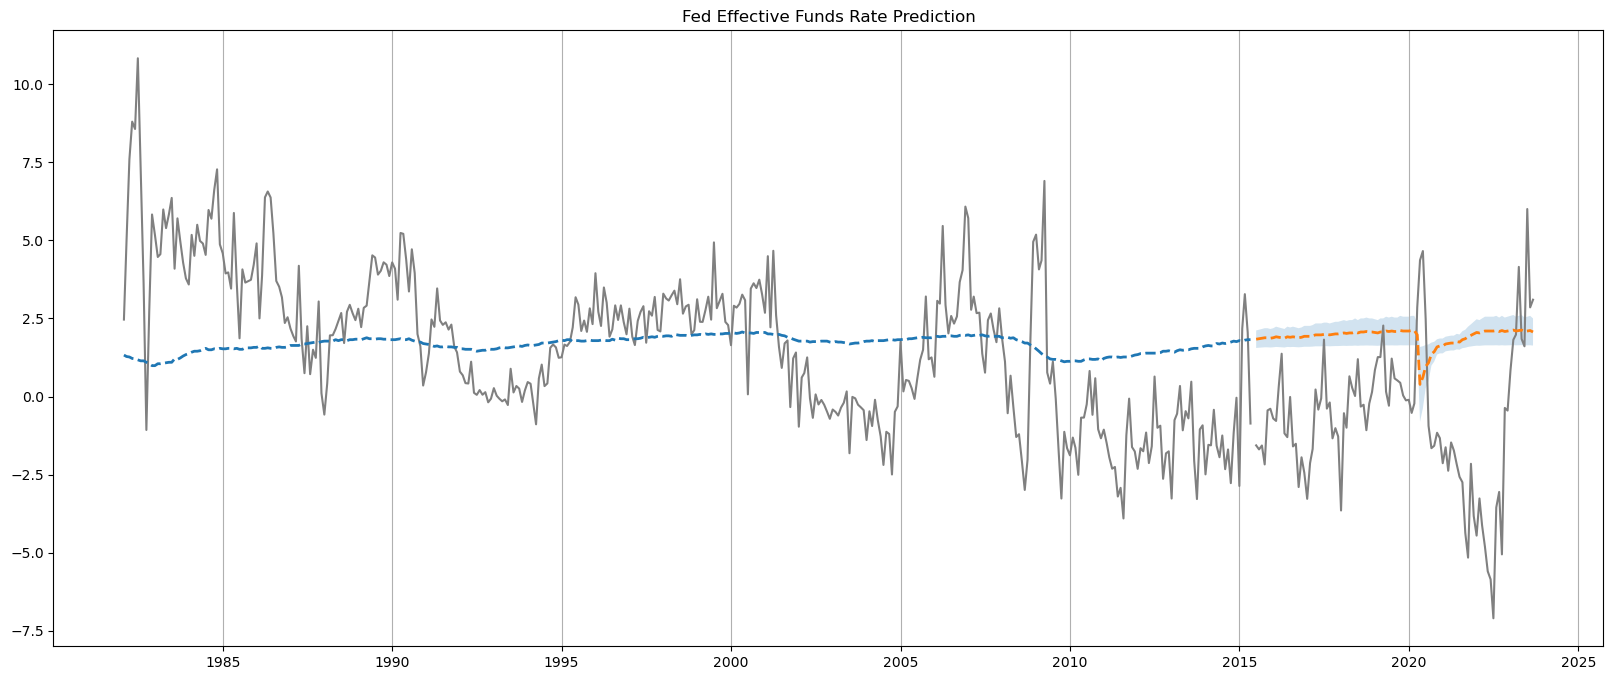

In [57]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['real_rate'], 'gray')
ax.plot(test_df.index, test_df['real_rate'], 'gray')
ax.plot(train_pred.index, train_pred['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred.index, test_pred['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred.index, test_pred['mean_ci_lower'], test_pred['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred.index, test_pred['obs_ci_lower'], test_pred['obs_ci_upper'], alpha=0.15)

ax.set(title='Fed Effective Funds Rate Prediction');

In [58]:
print('RMSE(Train):' , statsmodels.tools.eval_measures.rmse(train_df['real_rate'], train_pred['mean']))
print('RMSE(Test):' , statsmodels.tools.eval_measures.rmse(test_df['real_rate'], test_pred['mean']))

RMSE(Train): 2.375141316832083
RMSE(Test): 3.5823297331252273


In [59]:
print('R-Squard(Train):' , r2_score(train_df['real_rate'], train_pred['mean']))
print('R-Squard(Test):' , r2_score(test_df['real_rate'], test_pred['mean']))

R-Squard(Train): 0.011357217551253407
R-Squard(Test): -1.4162633890715646


In [60]:
print(ols_result.rsquared_adj)

0.008873190459673719


## tsa.SARIMAX

In [61]:
model = sm.tsa.SARIMAX(train_df['real_rate'], exog=train_df['un_emp_rate'])

In [62]:
result_model = model.fit(disp=False)

In [63]:
print(result_model.summary())

                               SARIMAX Results                                
Dep. Variable:              real_rate   No. Observations:                  400
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -640.478
Date:                Sun, 24 Sep 2023   AIC                           1286.957
Time:                        14:33:35   BIC                           1298.931
Sample:                    01-31-1982   HQIC                          1291.699
                         - 04-30-2015                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
un_emp_rate     0.2536      0.060      4.224      0.000       0.136       0.371
ar.L1           0.8732      0.021     41.011      0.000       0.831       0.915
sigma2          1.4346      0.076     18.985    

In [64]:
train_result = result_model.get_prediction(start=-len(train_df), dynamic=True)

In [65]:
train_pred = train_result.summary_frame()
train_pred

real_rate,mean,mean_se,mean_ci_lower,mean_ci_upper
DATE,,,,
1982-01-31,2.180913,2.45788,-2.636444,6.998269
1982-02-28,2.256991,2.45788,-2.560366,7.074348
1982-03-31,2.282350,2.45788,-2.535006,7.099707
1982-04-30,2.358429,2.45788,-2.458928,7.175785
1982-05-31,2.383788,2.45788,-2.433568,7.201145
...,...,...,...,...
2014-12-31,1.420129,2.45788,-3.397227,6.237486
2015-01-31,1.445489,2.45788,-3.371868,6.262845
2015-02-28,1.394770,2.45788,-3.422587,6.212126


In [66]:
s_idx = len(train_df)
e_idx = s_idx + len(test_df) - 1

In [67]:
test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=test_df['un_emp_rate'], dynamic=True)

In [68]:
test_pred = test_result.summary_frame()
test_pred

real_rate,mean,mean_se,mean_ci_lower,mean_ci_upper
2015-05-31,-0.607611,1.197763,-2.955183,1.739960
2015-06-30,-0.385551,1.590151,-3.502188,2.731087
2015-07-31,-0.194857,1.833777,-3.788993,3.399279
2015-08-31,-0.031553,1.999700,-3.950894,3.887788
2015-09-30,0.133193,2.117502,-4.017035,4.283422
...,...,...,...,...
2023-03-31,0.862216,2.457880,-3.955141,5.679572
2023-04-30,0.938295,2.457880,-3.879062,5.755651
2023-05-31,0.912936,2.457880,-3.904421,5.730292
2023-06-30,0.887577,2.457880,-3.929780,5.704933


In [69]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci

,lower real_rate,upper real_rate
2015-05-31,-1.415490,0.200267
2015-06-30,-1.458091,0.686989
2015-07-31,-1.431720,1.042007
2015-08-31,-1.380330,1.317225
2015-09-30,-1.295041,1.561427
...,...,...
2023-03-31,-0.795599,2.520031
2023-04-30,-0.719520,2.596110
2023-05-31,-0.744879,2.570751
2023-06-30,-0.770238,2.545392


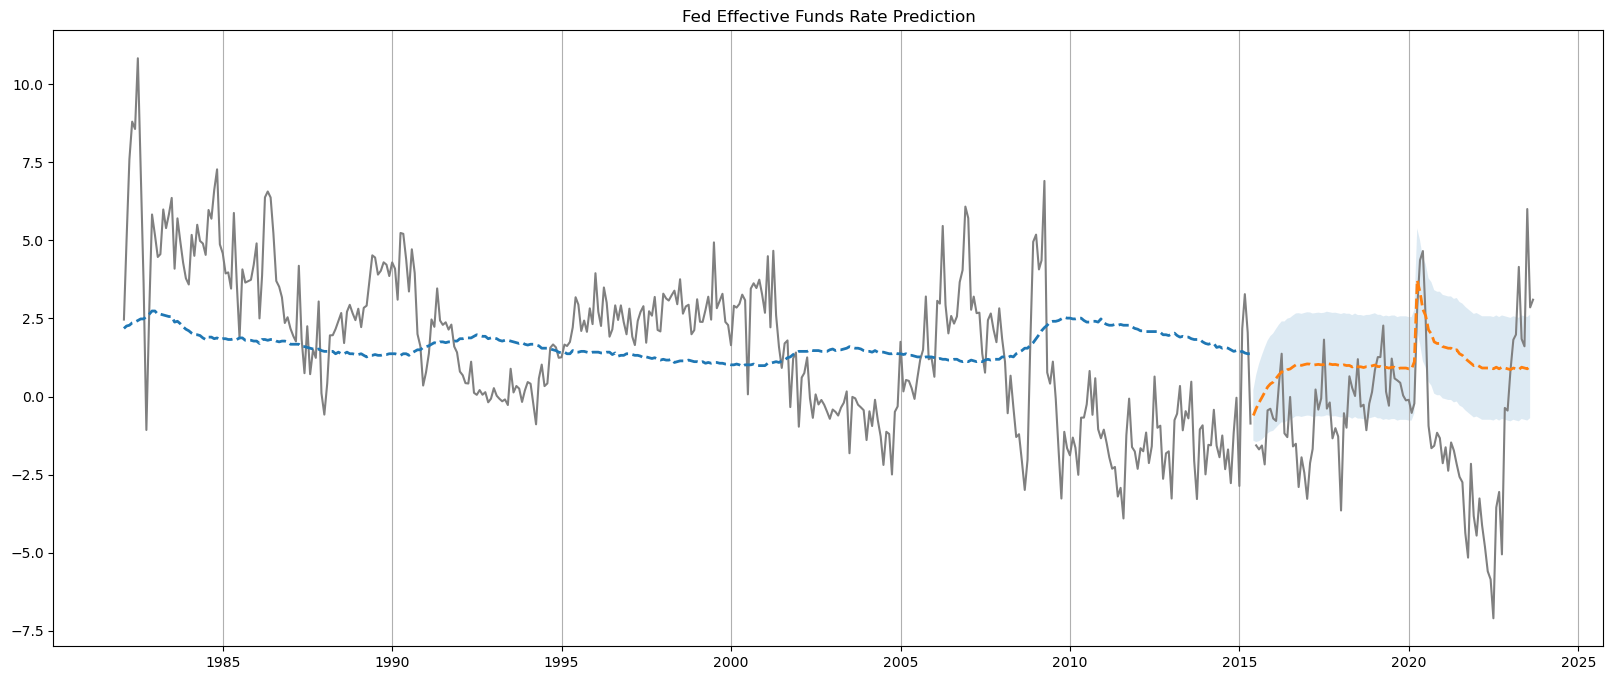

In [70]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['real_rate'], 'gray')
ax.plot(test_df.index, test_df['real_rate'], 'gray')
ax.plot(train_pred.index, train_pred['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred.index, test_pred['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred.index, predict_ci['lower real_rate'], predict_ci['upper real_rate'], alpha=0.15)

ax.set(title='Fed Effective Funds Rate Prediction');

In [71]:
print('SARIMAX RMSE(Train):' , statsmodels.tools.eval_measures.rmse(train_df['real_rate'], train_pred['mean']))
print('SARIMAX RMSE(Test):' , statsmodels.tools.eval_measures.rmse(test_df['real_rate'], test_pred['mean']))

SARIMAX RMSE(Train): 2.4693132977378593
SARIMAX RMSE(Test): 2.9108096379999724


In [72]:
print('SARIMAX R-Squard(Train):' , r2_score(train_df['real_rate'], train_pred['mean']))
print('SARIMAX R-Squard(Test):' , r2_score(test_df['real_rate'], test_pred['mean']))

SARIMAX R-Squard(Train): -0.06859436942916552
SARIMAX R-Squard(Test): -0.5952941281338515


In [73]:
print('SARIMAX R-Squard:' , r2_score(test_df['real_rate'], test_pred['mean']))

SARIMAX R-Squard: -0.5952941281338515


# inflation

## stats model

In [74]:
X = train_df['cpi_rate']
X = sm.add_constant(X)
X

,const,cpi_rate
DATE,,
1982-01-31,1.0,0.368790
1982-02-28,1.0,0.427160
1982-03-31,1.0,-0.020060
1982-04-30,1.0,0.907520
1982-05-31,1.0,1.110180
...,...,...
2014-12-31,1.0,0.116414
2015-01-31,1.0,0.168069
2015-02-28,1.0,0.140280


In [75]:
ols_model = sm.OLS(y, X)
ols_result = ols_model.fit()

In [76]:
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:              real_rate   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     130.8
Date:                Sun, 24 Sep 2023   Prob (F-statistic):           2.24e-26
Time:                        14:33:36   Log-Likelihood:                -859.07
No. Observations:                 400   AIC:                             1722.
Df Residuals:                     398   BIC:                             1730.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5583      0.221     -2.530      0.0

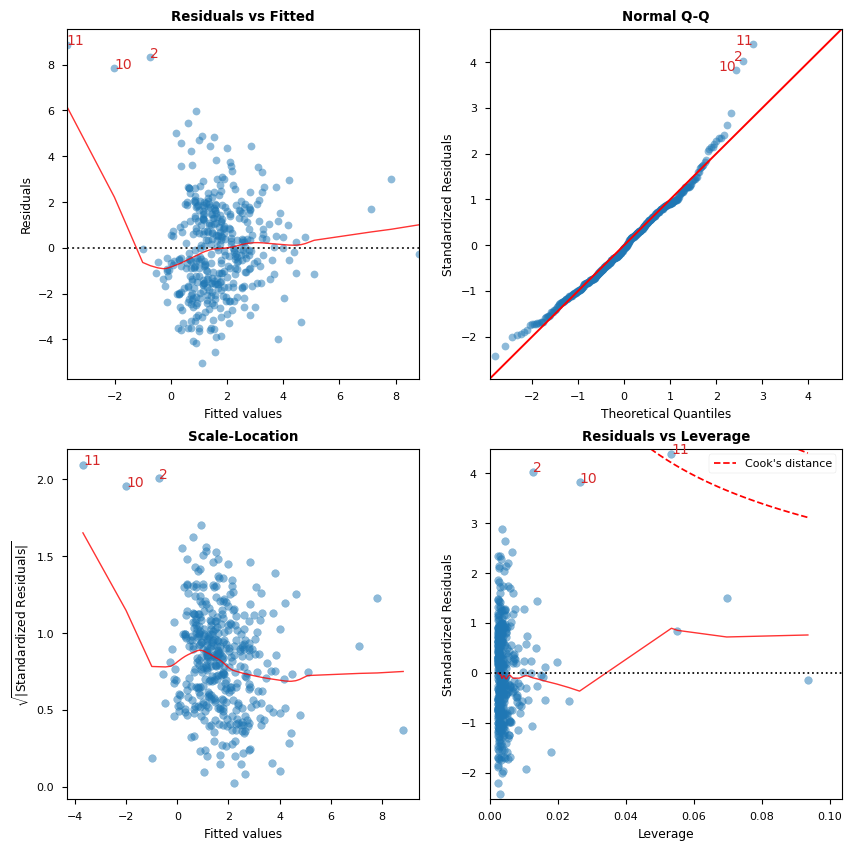

   Features  VIF Factor
0     const    4.511918
1  cpi_rate    1.000000


In [77]:
cls = LinearRegDiagnostic(ols_result)
vif, fig, ax = cls()
print(vif)

In [78]:
train_pred = ols_result.predict(X)
train_pred

DATE
1982-01-31    2.562209
1982-02-28    3.056107
1982-03-31   -0.728043
1982-04-30    7.120670
1982-05-31    8.835477
                ...   
2014-12-31    0.426731
2015-01-31    0.863810
2015-02-28    0.628673
2015-03-31    1.304662
2015-04-30    1.766194
Freq: M, Length: 400, dtype: float64

In [79]:
print('r2 score:', r2_score(train_pred, train_df['real_rate']))
print(ols_result.params[:])

r2 score: -2.04387344696204
const      -0.558305
cpi_rate    8.461494
dtype: float64


In [80]:
X_test = test_df['cpi_rate']
#X_test = sm.add_constant(X_test)
X_test 

DATE
2015-06-30    0.218324
2015-07-31    0.195411
2015-08-31    0.138176
2015-09-30    0.248410
2015-10-31    0.254499
                ...   
2023-04-30    0.382205
2023-05-31    0.324257
2023-06-30    0.233532
2023-07-31    0.264675
2023-08-31    0.393906
Freq: M, Name: cpi_rate, Length: 99, dtype: float64

In [81]:
t = ols_result.get_prediction(X_test)
test_pred = t.summary_frame(alpha=0.05)
test_pred

ValueError: shapes (1,99) and (2,) not aligned: 99 (dim 1) != 2 (dim 0)

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['real_rate'], 'gray')
ax.plot(test_df.index, test_df['real_rate'], 'gray')
ax.plot(train_pred.index, train_pred, linestyle='--', linewidth=2)
ax.plot(test_pred.index, test_pred['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred.index, test_pred['mean_ci_lower'], test_pred['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred.index, test_pred['obs_ci_lower'], test_pred['obs_ci_upper'], alpha=0.15)

ax.set(title='Fed Effective Funds Rate Prediction');

In [ ]:
print('RMSE(Train):' , statsmodels.tools.eval_measures.rmse(train_df['real_rate'], train_pred))
print('RMSE(Test):' , statsmodels.tools.eval_measures.rmse(test_df['real_rate'], test_pred['mean']))

In [ ]:
print('R-Squard(Train):' , r2_score(train_df['real_rate'], train_pred))
print('R-Squard(Test):' , r2_score(test_df['real_rate'], test_pred['mean']))

In [ ]:
print(ols_result.rsquared_adj)

## tsa.SARIMAX

In [ ]:
model = sm.tsa.SARIMAX(train_df['real_rate'], exog=train_df['cpi_rate'])

In [ ]:
result_model = model.fit(disp=False)

In [ ]:
print(result_model.summary())

In [ ]:
train_result = result_model.get_prediction(start=-len(train_df), dynamic=True)

In [ ]:
train_pred = train_result.summary_frame()
train_pred

In [ ]:
s_idx = len(train_df)
e_idx = s_idx + len(test_df) - 1

In [ ]:
test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=test_df['cpi_rate'], dynamic=True)

In [ ]:
test_pred = test_result.summary_frame()
test_pred

In [ ]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['real_rate'], 'gray')
ax.plot(test_df.index, test_df['real_rate'], 'gray')
ax.plot(train_pred.index, train_pred['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred.index, test_pred['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred.index, predict_ci['lower real_rate'], predict_ci['upper real_rate'], alpha=0.15)

ax.set(title='Fed Effective Funds Rate Prediction');

In [ ]:
print('SARIMAX RMSE(Train):' , statsmodels.tools.eval_measures.rmse(train_df['real_rate'], train_pred['mean']))
print('SARIMAX RMSE(Test):' , statsmodels.tools.eval_measures.rmse(test_df['real_rate'], test_pred['mean']))

In [ ]:
print('R-Squard(Train):' , r2_score(train_df['real_rate'], train_pred['mean']))
print('R-Squard(Test):' , r2_score(test_df['real_rate'], test_pred['mean']))